## Modelling phase

In the modelling phase, we will focus on building, training, and evaluating the machine learning models to determine the best model for predicting the target variable that is 'SalePrice'. The process includes:

> **Data splitting**: We will split the dataset into training and testing sets. Then, we will use the training set to train the models and the testing set to evaluate the performance of the models.

> **Preprocessing:** Since there are categorical and numerical variables in the dataset, we will use ColumnTransformer to convert handle them accordingly

> **Model Benchmarking:** Comparing multiple machine learning model to identify the best performing model.

> **Evaluation Metrics:** Cross-Validation RMSE and Test RMSE will be used to evaluate the performance of the models.

> **Hyperparameter Tuning:** We will use GridSearchCV to tune the hyperparameters of the best model.

## Data Splitting

In [1]:
# Import the clean data first

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

filepath = r'C:\Users\Asus\Desktop\DS Purwa\Module_3\Capstone Module 3\CSV File\Daegu_Cleaned.csv'
df_raw = pd.read_csv(filepath, index_col=0)
df = df_raw.copy()
df.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504


In [2]:
# Import necessary libraries 
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Seperate the target variable and other features.
X = df.drop(columns='SalePrice')
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We have split the data and now we start the preprocessing step

# Preprocessing

In [3]:
# Since there are numerical and categorical features, we need to assign them in a different variables
numerical_cols = ['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)',
                    'N_SchoolNearBy(University)', 'N_Parkinglot(Basement)', 'YearBuilt',
                    'N_FacilitiesInApt', 'Size(sqf)']

categorical_cols = df.select_dtypes(include=['object']).columns

In [4]:
# Apply column transformer to preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

We have done the preprocessing of the data and now we need to assign the models that we are going to benchmark

# Model Benchmark

The model that we have chosen are Linear regression, Random Forest Regression, Decision Tree Regression, and SVR

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

models = {
    'Linear Regression' : LinearRegression(),
    'Random Forest' : RandomForestRegressor(),
    'Decision Tree' : DecisionTreeRegressor(),
    'SVR' : SVR()
}

In [6]:
result = []

In [7]:
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('processor', preprocessor), ('model', model)])
    
    # Cross validation metrics
    y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

    rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))
    r2_cv = r2_score(y_train, y_pred_cv)
    mae = mean_absolute_error(y_train, y_pred_cv)

    # Now for the test set
    pipeline.fit(X_train, y_train)
    y_pred_test = pipeline.predict(X_test)

    # Test metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # Append the results to the result list
    result.append({
        'Model' : model_name,
        'RMSE CV' : rmse_cv,
        'R2 CV' : r2_cv,
        'MAE CV' : mae,
        'RMSE Test' : rmse_test,
        'R2 Test' : r2_test,
        'MAE Test' : mae_test
    })      

benchmark_result = pd.DataFrame(result)
benchmark_result

,Model,RMSE CV,R2 CV,MAE CV,RMSE Test,R2 Test,MAE Test
0,Linear Regression,52234.498573,0.744864,42215.588762,52720.478214,0.735024,42667.252001
1,Random Forest,47359.204711,0.790267,38333.859502,45825.992530,0.799796,37361.577705
2,Decision Tree,47318.130525,0.790631,38292.055168,45886.133296,0.799270,37474.826842
3,SVR,103632.293044,-0.004262,83426.473518,102673.450348,-0.004997,82064.017299


When we look at the result of the benchmark, we can see that they are far from being considered a good model. We can make some adjustment in the model selection, or even changing the scaling method. The next part will be called Attempt #2

# Attempt #2

In this part, we will try to modified the scaling and change it accordingly.

In [8]:
from sklearn.preprocessing import RobustScaler

# Define which columns to scale and specified the scaler

numerical_col_standard = ['N_FacilitiesNearBy(ETC)', 'N_FacilitiesNearBy(PublicOffice)', 'N_SchoolNearBy(University)', 'YearBuilt', 'Size(sqf)']
numerical_cols_robust = ['N_Parkinglot(Basement)']
categorical_cols = ['HallwayType', 'TimeToSubway', 'SubwayStation']

# Create the column transformer

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('Standard', StandardScaler(), numerical_col_standard),
        ('Robust', RobustScaler(), numerical_cols_robust),
        ('Cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [9]:
result_2 = []

In [10]:
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('processor', preprocessor_2), ('model', model)])
    
    # Cross validation metrics
    y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

    rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))
    r2_cv = r2_score(y_train, y_pred_cv)
    mae = mean_absolute_error(y_train, y_pred_cv)

    # Now for the test set
    pipeline.fit(X_train, y_train)
    y_pred_test = pipeline.predict(X_test)

    # Test metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # Append the results to the result list
    result_2.append({
        'Model' : model_name,
        'RMSE CV' : rmse_cv,
        'R2 CV' : r2_cv,
        'MAE CV' : mae,
        'RMSE Test' : rmse_test,
        'R2 Test' : r2_test,
        'MAE Test' : mae_test
    })      

benchmark_result_2 = pd.DataFrame(result_2)
benchmark_result_2

,Model,RMSE CV,R2 CV,MAE CV,RMSE Test,R2 Test,MAE Test
0,Linear Regression,53150.914206,0.735833,43007.287451,53758.624804,0.724485,43690.327102
1,Random Forest,47341.453622,0.790425,38331.747225,45768.515186,0.800298,37353.645118
2,Decision Tree,47367.871033,0.790191,38313.490368,45886.133296,0.799270,37474.826842
3,SVR,103625.639361,-0.004133,83420.672669,102666.663828,-0.004864,82057.130554


Lets compare them to the first attempt

In [11]:
models_graph = ['Linear Regression', 'Random Forest', 'Decision Tree', 'SVR']

original_rmse_test = benchmark_result['RMSE Test'].values
original_r2_test = benchmark_result['R2 Test'].values
original_mae_test = benchmark_result['MAE Test'].values

second_attempt_rmse_test = benchmark_result_2['RMSE Test'].values
second_attempt_r2_test = benchmark_result_2['R2 Test'].values
second_attempt_mae_test = benchmark_result_2['MAE Test'].values

performance_data = pd.DataFrame({
    'Model': models_graph,
    'Original RMSE Test': original_rmse_test,
    'Second Attempt RMSE Test': second_attempt_rmse_test,
    'Original R2 Test': original_r2_test,
    'Second Attempt R2 Test': second_attempt_r2_test,
    'Original MAE Test': original_mae_test,
    'Second Attempt MAE Test': second_attempt_mae_test
})

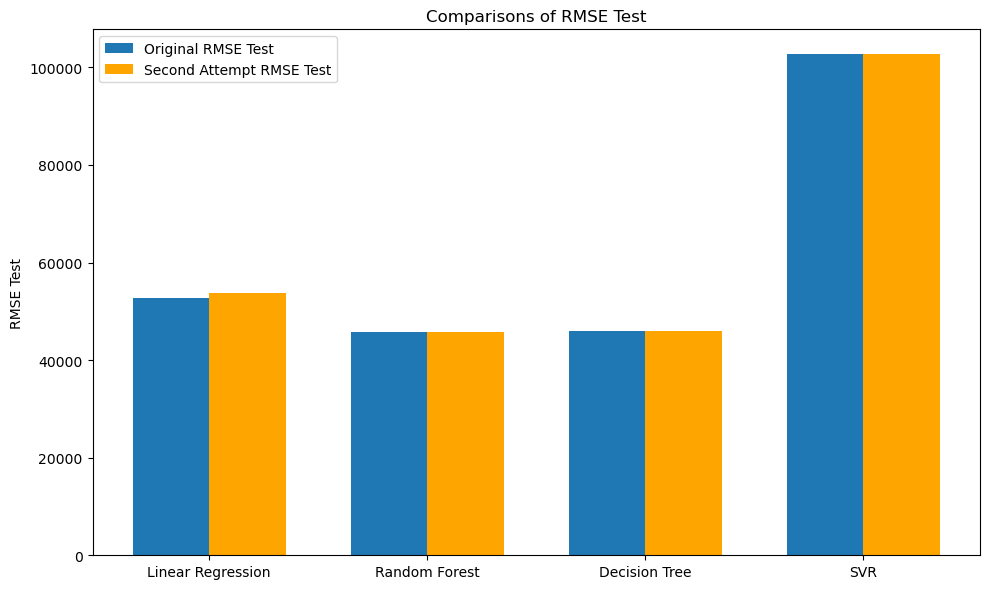

In [12]:
# RMSE Test Comparison
x = np.arange(len(models_graph))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_rmse_test, width, label='Original RMSE Test')
plt.bar(x + width/2, second_attempt_rmse_test, width, label='Second Attempt RMSE Test', color='orange')
plt.title('Comparisons of RMSE Test')
plt.xticks(x, models_graph)
plt.ylabel('RMSE Test')
plt.legend()
plt.tight_layout()
plt.show()

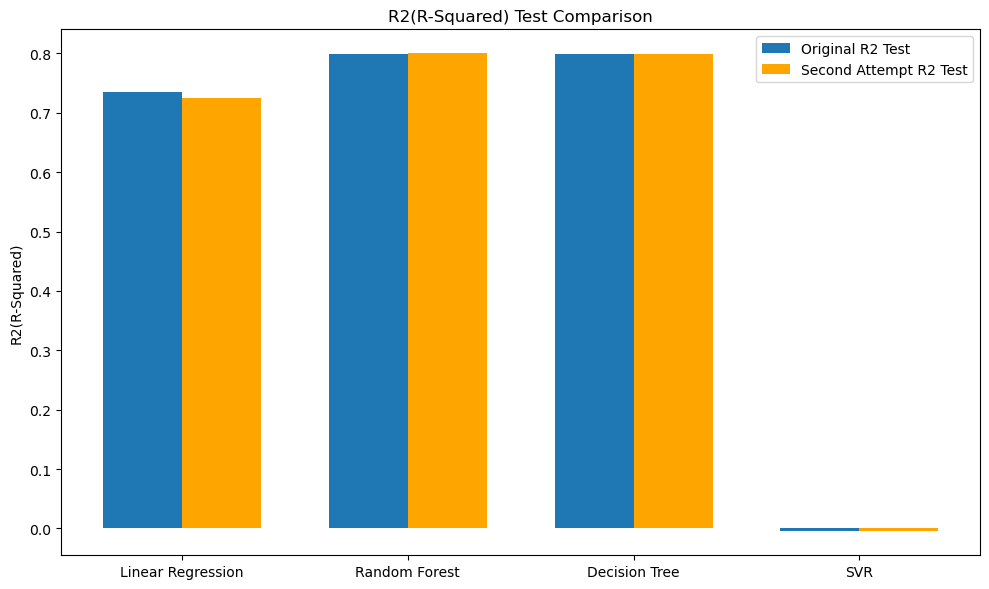

In [13]:
# R2 Test
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_r2_test, width, label='Original R2 Test')
plt.bar(x + width/2, second_attempt_r2_test, width, label='Second Attempt R2 Test', color='orange')
plt.title('R2(R-Squared) Test Comparison')
plt.xticks(x, models_graph)
plt.ylabel('R2(R-Squared)')
plt.legend()
plt.tight_layout()
plt.show()

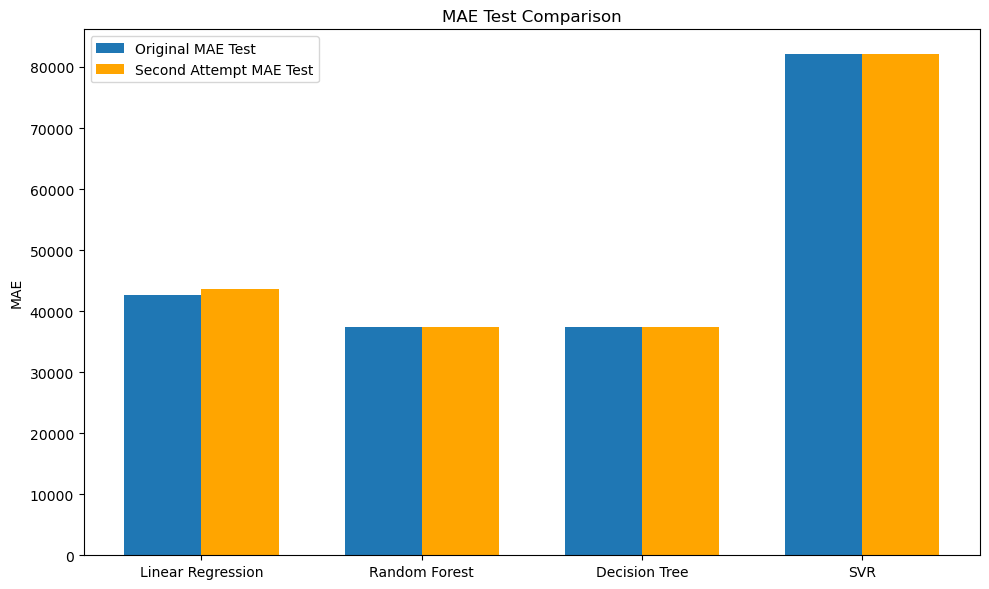

In [14]:
# MAE Result Comparison
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_mae_test, width, label='Original MAE Test')
plt.bar(x + width/2, second_attempt_mae_test, width, label='Second Attempt MAE Test', color='orange')
plt.title('MAE Test Comparison')
plt.xticks(x, models_graph)
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

The insights we gained:<BR><BR>
**RMSE**
* Linear regression model worsened after changing the scaling method
* Random Forest and Decision Tree remained stable with small or no changes.
* SVR had a high RMSE, reflecting poor performance.

**R2 (R-Squared)**<br>

* Linear Regression showed a slight improvement in explaining the target variance.
* Random Forest and Decision Tree had high and stable R2 values.
* SVR showed a negative R2, indicating poor performance. 

**MAE**<br>
* Linear Regression improved with a lower error after adjustments.
* Random Forest and Decision Tree maintained low MAE, showing consistent performance.
* SVR had a very high MAE, signaling inaccurate predictions.


## Attempt #3

We can conclude that changing the scaling does little effect on the model performance. The next attempt, we will now try adding new models into the mix. The new models that we will try are:
* XGBoost
* Lidge
* Lasso
* LightGBM

From the previous attempt, SVR show a bad performance. Therefore, we will not include it in this next attempt.

In [15]:
from sklearn.linear_model import Ridge, Lasso
from lightgbm import LGBMRegressor
import xgboost as xgb

models_2 = {
    'Linear Regression' : LinearRegression(),
    'Random Forest' : RandomForestRegressor(),
    'Decision Tree' : DecisionTreeRegressor(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
   'XGBoost' : xgb.XGBRegressor(),
   'LightGBM' : LGBMRegressor()
}

In [16]:
result_3 = []

In [17]:
for model_name, model in models_2.items():
    pipeline = Pipeline(steps=[('processor', preprocessor_2), ('model', model)])
    
    # Cross validation metrics
    y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

    rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))
    r2_cv = r2_score(y_train, y_pred_cv)
    mae = mean_absolute_error(y_train, y_pred_cv)

    # Now for the test set
    pipeline.fit(X_train, y_train)
    y_pred_test = pipeline.predict(X_test)

    # Test metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # Append the results to the result list
    result_3.append({
        'Model' : model_name,
        'RMSE CV' : rmse_cv,
        'R2 CV' : r2_cv,
        'MAE CV' : mae,
        'RMSE Test' : rmse_test,
        'R2 Test' : r2_test,
        'MAE Test' : mae_test
    })      

benchmark_result_3 = pd.DataFrame(result_3)
benchmark_result_3

c:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+11, tolerance: 1.805e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.541e+11, tolerance: 1.725e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.646e+11, tolerance: 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 1672, number of used features: 22
[LightGBM] [Info] Start training from score 228991.008971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 154
[LightGBM] [Info] Number of data points in the train set: 1672, number of used features: 22
[LightGBM] [Info] Start training from score 227106.858852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

,Model,RMSE CV,R2 CV,MAE CV,RMSE Test,R2 Test,MAE Test
0,Linear Regression,53150.914206,0.735833,43007.287451,53758.624804,0.724485,43690.327102
1,Random Forest,47320.014589,0.790614,38290.863898,45843.465834,0.799644,37293.340933
2,Decision Tree,47279.583796,0.790972,38252.748980,45886.133296,0.799270,37474.826842
3,Ridge,53147.282393,0.735869,43016.654740,53749.199760,0.724582,43694.631989
4,Lasso,53150.365171,0.735839,43006.783671,53758.060607,0.724491,43690.166974
5,XGBoost,47397.187576,0.789931,38339.322047,45885.866542,0.799273,37474.569760
6,LightGBM,47249.127567,0.791241,38390.312848,45937.062859,0.798825,37523.781749


From the result of the benchmark, the best performing models are:
* Random Forest
* XGBoost

The next step we will try to improve the performance of these models by using hyperparameter tuning.

**Random Forest Regressor**

In [18]:
from sklearn.model_selection import GridSearchCV

random_forest_ct = ColumnTransformer(
    transformers=[
        ('Standard', StandardScaler(), numerical_col_standard),
        ('Robust', RobustScaler(), numerical_cols_robust),
        ('Cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [19]:
random_forest = RandomForestRegressor()

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', random_forest_ct),
    ('model', random_forest)
])

In [20]:
param_grid = {
    'model__max_depth': [10, 20, 30, None],          
    'model__n_estimators': [50, 100, 200],          
    'model__min_samples_split': [2, 5, 10],         
    'model__min_samples_leaf': [1, 2, 4]         
}

grid_search = GridSearchCV(estimator=random_forest_pipeline, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_degree_tree = grid_search.best_estimator_

y_pred_tree = best_degree_tree.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse = mse_tree ** 0.5
r2 = r2_score(y_test, y_pred_tree)
mae = mean_absolute_error(y_test, y_pred_tree)

best_params = grid_search.best_params_

print("Best parameters: ", best_params)
print("RMSE: ", rmse)
print('R2: ', r2)
print('MAE: ', mae)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:  {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}
RMSE:  45918.239617278115
R2:  0.7989895025301899
MAE:  37461.1656258787


This is the best result for random forest, lets now applied it into the model

In [21]:
best_model = RandomForestRegressor(    
    max_depth=None, 
    min_samples_leaf=1, 
    min_samples_split=10, 
    n_estimators=100,
    random_state=42
)

best_model_pipeline = Pipeline(steps=[
    ('preprocessor', random_forest_ct),
    ('model', best_model)
])

In [22]:
best_model_pipeline.fit(X_train, y_train)
y_pred_best_model = best_model_pipeline.predict(X_test)


print('Random Forest Regressor Result: ')
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_best_model)))
print('R2 score: ', r2_score(y_test, y_pred_best_model))
print('MAE: ', mean_absolute_error(y_test, y_pred_best_model))

Random Forest Regressor Result: 
RMSE:  45981.75039682988
R2 score:  0.7984330716986854
MAE:  37470.421498574826


Now, we use XGBoost to compare with random forest

In [23]:
from xgboost import XGBRegressor

XGB = XGBRegressor()

XGB_ct = ColumnTransformer(
    transformers=[
        ('Standard', StandardScaler(), numerical_col_standard),
        ('Robust', RobustScaler(), numerical_cols_robust),
        ('Cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [24]:
XGB_Pipeline = Pipeline(steps=[
    ('preprocessor', XGB_ct),
    ('model', XGB)
])

In [25]:
param_grid = {
    'model__n_estimators': [100, 200, 300],  
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'model__max_depth': [3, 4, 5, 6, 7, 8],  
    'model__min_child_weight': [1, 2, 3, 4, 5],
    'model__subsample': [0.6, 0.8, 1.0],  
}

grid_search_xgb = GridSearchCV(estimator=XGB_Pipeline, param_grid=param_grid, cv=5, 
                           n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

grid_search_xgb.fit(X_train, y_train)
best_estimator_xgb = grid_search_xgb.best_estimator_

y_pred_xgb = grid_search_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

best_params_xgb = grid_search_xgb.best_params_

print("Best Parameters for XGBoost: ", best_params_xgb)
print("RMSE for XGBoost: ", rmse_xgb)
print("R2 Score for XGBoost: ", r2_xgb)
print("MAE for XGBoost: ", mae_xgb)


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best Parameters for XGBoost:  {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 100, 'model__subsample': 0.8}
RMSE for XGBoost:  45811.276588197405
R2 Score for XGBoost:  0.7999248889803905
MAE for XGBoost:  37487.57399468212


Now apply the best parameter to the model

In [26]:
xgb_best_model = XGBRegressor(
    learning_rate = 0.1, 
    max_depth = 3, 
    min_child_weight = 1, 
    n_estimators = 100, 
    subsample = 0.8
)

xgb_best_model_pipeline = Pipeline(steps=[
    ('preprocessor', XGB_ct),
    ('model', xgb_best_model)
])

In [27]:
xgb_best_model_pipeline.fit(X_train, y_train)
y_pred_xgb_best_model = xgb_best_model_pipeline.predict(X_test)

print('XGBRegressor Result: ')
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_xgb_best_model)))
print('R2 score: ', r2_score(y_test, y_pred_xgb_best_model))
print('MAE: ', mean_absolute_error(y_test, y_pred_xgb_best_model))

XGBRegressor Result: 
RMSE:  45811.276588197405
R2 score:  0.7999248889803905
MAE:  37487.57399468212


When we compare the two best performing models, we can see that XGBRegrssor yields the best result. It is concluded that XBGRegressor is the best model for predicting the price of apartment based on its features.

**Residual Analysis**

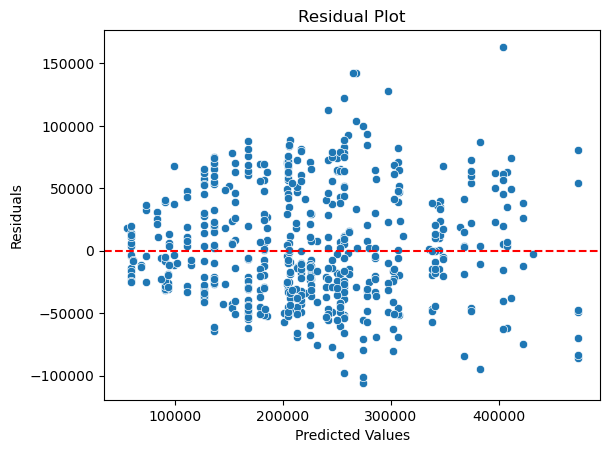

In [28]:
residuals = y_test - y_pred_xgb
sns.scatterplot(x=y_pred_xgb, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

**Start from hyperparameter tuning using logarithmic scale**

In [44]:
from sklearn.compose import TransformedTargetRegressor

log_xgb = TransformedTargetRegressor(regressor=XGB, func=np.log, inverse_func=np.exp)

log_xgb_pipeline = Pipeline(steps=[('preprocessor', XGB_ct), ('model', log_xgb)])

In [45]:
param_grid = {
    'model__regressor__n_estimators': [100, 200],
    'model__regressor__learning_rate': [0.01, 0.1, 0.2],
    'model__regressor__max_depth': [3, 5, 7],
    'model__regressor__subsample': [0.8, 1.0],
    'model__regressor__colsample_bytree': [0.8, 1.0],
    'model__regressor__gamma': [0, 0.1, 0.2]
}

In [46]:
grid_search_log_xgb = GridSearchCV(estimator=log_xgb_pipeline, param_grid=param_grid, cv=5, 
                                   n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

grid_search_log_xgb.fit(X_train, y_train)
y_pred_log_xgb = grid_search_log_xgb.predict(X_test)

mse_log_xgb = mean_squared_error(y_test, y_pred_log_xgb)
rmse_log_xgb = np.sqrt(mse_log_xgb)
r2_log_xgb = r2_score(y_test, y_pred_log_xgb)
mae_log_xgb = mean_absolute_error(y_test, y_pred_log_xgb)

print("Best Parameters: ", grid_search_log_xgb.best_params_)
print("RMSE: ", rmse_log_xgb)
print("R2 Score: ", r2_log_xgb)
print("MAE: ", mae_log_xgb)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters:  {'model__regressor__colsample_bytree': 0.8, 'model__regressor__gamma': 0, 'model__regressor__learning_rate': 0.2, 'model__regressor__max_depth': 3, 'model__regressor__n_estimators': 100, 'model__regressor__subsample': 0.8}
RMSE:  46230.438196264295
R2 Score:  0.7962468656699799
MAE:  37189.40413629302


In [68]:
best_params = grid_search_log_xgb.best_params_
best_model_xgb = XGBRegressor(**best_params)
log_xgb_best = TransformedTargetRegressor(regressor=best_model_xgb, func=np.log, inverse_func=np.exp)
best_xgb_model_pipeline = Pipeline(steps=[('preprocessor', XGB_ct), ('model', log_xgb_best)])
best_xgb_model_pipeline.fit(X_train, y_train)
y_pred_log_xgb = best_xgb_model_pipeline.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_log_xgb)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_log_xgb)
mae_best = mean_absolute_error(y_test, y_pred_log_xgb)

print('XGBRegressor Result:')
print('RMSE: ', rmse_best)
print('R2 Score: ', r2_best)
print('MAE: ', mae_best)

XGBRegressor Result:
RMSE:  46321.73653230587
R2 Score:  0.7954413059009947
MAE:  37196.98407624283


c:\Users\Asus\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [22:19:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "model__regressor__colsample_bytree", "model__regressor__gamma", "model__regressor__learning_rate", "model__regressor__max_depth", "model__regressor__n_estimators", "model__regressor__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


Residual Analysis

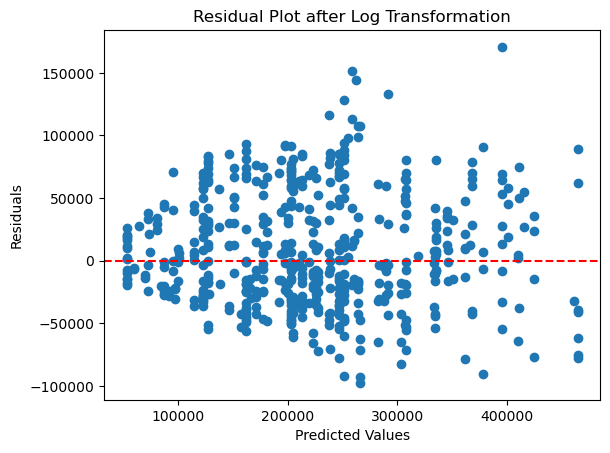

In [69]:
residuals = y_test - y_pred_log_xgb

plt.scatter(y_pred_log_xgb, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot after Log Transformation')
plt.show()


**Feature Importance**

In [54]:
best_model = grid_search_log_xgb.best_estimator_.named_steps['model'].regressor_
importances = best_model.feature_importances_

In [57]:
feature_names = XGB_ct.get_feature_names_out() 
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

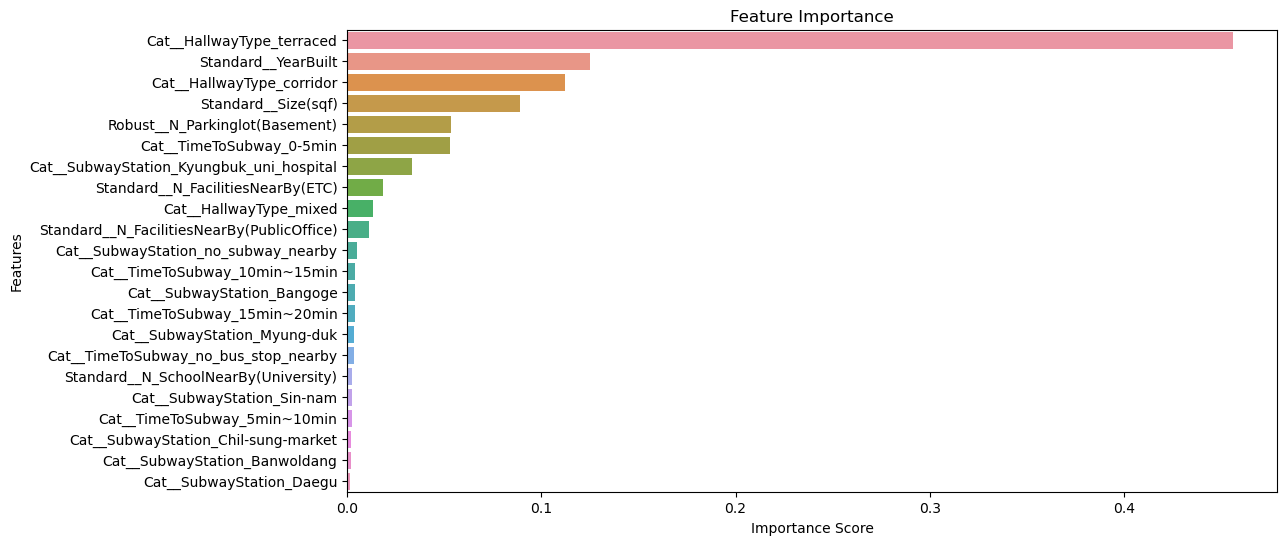

In [59]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df) 
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## Project Conclusions and Business Recommendation

**Key Insights**
* Feature Importance:
The most significant predictors of apartment prices are:

* Hallway Type (terraced): This feature had the highest importance, underscoring the preference for terraced hallway designs in apartment layouts.
* Year Built: Newer apartments were associated with higher prices, reflecting buyers' preference for modern amenities and construction.
* Apartment Size (sq ft): Larger apartments command higher prices, as expected.
* Time to Subway (0–5 minutes): Apartments closer to subway stations are highly valued, making accessibility a key factor.
* Parking Availability: The presence of basement parking adds considerable value to apartments, as it enhances convenience.<br>

* Log transformation: By applying a logarithmic transformation to the target variable, the model provided more stable predictions, especially when dealing with skewed price distributions.

**Business Recommendation**
* Adjust apartment pricing dynamically based on the most impactful features, such as hallway type, age of the building, size, and proximity to transportation.
* Leverage data-driven insights to identify premium pricing opportunities for apartments with desirable characteristics (e.g., terraced hallways, proximity to subways).
* Highlight top features like modern hallway designs, accessible subway locations, and larger apartment sizes in marketing materials.
* Segment customers based on their preferences and target campaigns accordingly—for instance, promoting spacious apartments to families or emphasizing accessibility to professionals.
* Focus on constructing or upgrading properties with terraced hallways and modern layouts.
* Prioritize projects near subway stations (0–5 minutes’ walking distance) and ensure parking availability to enhance property value.



The next part will be saving at pickle file.

In [70]:
import pickle

with open('Apartment Daegu Best Model.pkl', 'wb') as model_file:
    pickle.dump(best_xgb_model_pipeline, model_file)

print("Model saved successfully to 'Apartmennt Daegu Best Model.pkl'")

Model saved successfully to 'Apartmennt Daegu Best Model.pkl'
